## BBC News Dataset Clustering and Classification

## 1.Importing all the frameworks and libraries

In [166]:
# import basic libraries
import pandas as pd
import numpy as np
import os
import re
import random
import string
import nltk
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk import word_tokenize

nltk.download('stopwords')
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('omw-1.4')
warnings.filterwarnings(action = 'ignore')


from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import cluster 
from sklearn import metrics
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE 
from gensim.models import Word2Vec

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sarika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sarika\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sarika\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Sarika\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [167]:
np.random.seed(500)


## 2.Importing Dataset


In [171]:
#Training Dataset
dataset = pd.read_csv('C:/Users/Sarika/Documents/Sem_II/Text As Data/coursework/BBC_News.csv')


In [172]:
dataset.head()

,Category,Text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [174]:
# delete the duplicate article
dataset=dataset.drop_duplicates(subset={"Category","Text"}, keep='first', inplace=False)
dataset.shape 

(2126, 2)

In [175]:
df = dataset.iloc[:2500]


In [176]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2126 non-null   object
 1   Text      2126 non-null   object
dtypes: object(2)
memory usage: 49.8+ KB


(2126, 2)

File descriptions

This is a public dataset from BBC. It consists of 2225 articles. Each article is labeled in one of 5 categories.

a. Business
b. Entertainment
c. Politics
d. Sports
e. Tech

The dataset is divided into Train Dataset and Test Dataset. Train dataset consists of 1490 records and test dataset consists of 735 records. Purpose of this exercise is to build an algorithm to accurately classify unseen news article into correct category using different classification algorithms and evaluate the performance of different classifiers.

BBC News Train.csv - the training set of 1490 records
BBC News Test.csv - the test set of 736 records



In [177]:
Category_count = df.groupby("Category").count()
print(Category_count)

               Text
Category           
business        503
entertainment   369
politics        403
sport           504
tech            347


Text(0, 0.5, 'Article Count')

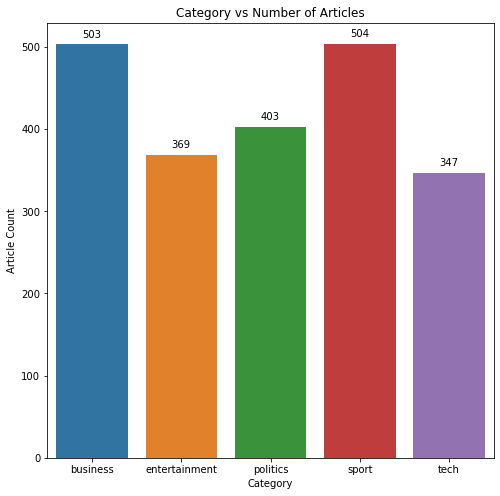

In [178]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 8))
barchart = sns.barplot(x=Category_count.index, y=Category_count['Text'], ax=ax)
barchart.bar_label(ax.containers[0], label_type='edge', padding=5)
plt.title('Category vs Number of Articles')
plt.xlabel('Category')
plt.ylabel('Article Count')

### Stop Words Removal, Stemming and Tokenizing

In [179]:
#Remove the stopwords from Text column
# Import stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords.words('english')
stemmer = PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()


In [180]:
# Text cleaning and pre=processing 
def text_to_words(raw_text):
  
    # 1. Remove non aplhabets       
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text) 
    
   # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()
        
    # 3. Remove Stopwords. 
    stops = set(stopwords.words("english")) 
    
    
    # 4. Remove stop words
    meaningful_words = [w for w in words if not w in stops] 
    
    
    # 5. Lemmatization
    lem_text = [lemmatizer.lemmatize(w) for w in meaningful_words]
        
    # 6. Join the words back into one string separated by space , and return the result.
    return( " ".join( lem_text )) 

In [181]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df['clean_text'] = [text_to_words(text) for text in df['Text']]
print(df.head(10))

        Category                                               Text  \
0           tech  tv future in the hands of viewers with home th...   
1       business  worldcom boss  left books alone  former worldc...   
2          sport  tigers wary of farrell  gamble  leicester say ...   
3          sport  yeading face newcastle in fa cup premiership s...   
4  entertainment  ocean s twelve raids box office ocean s twelve...   
5       politics  howard hits back at mongrel jibe michael howar...   
6       politics  blair prepares to name poll date tony blair is...   
7          sport  henman hopes ended in dubai third seed tim hen...   
8          sport  wilkinson fit to face edinburgh england captai...   
9  entertainment  last star wars  not for children  the sixth an...   

                                          clean_text  
0  tv future hand viewer home theatre system plas...  
1  worldcom bos left book alone former worldcom b...  
2  tiger wary farrell gamble leicester say rushed... 

### Unsupervised Learning : K-Means Clustering

In [182]:
#Applying TF-IDF Vectorizer 

from sklearn.feature_extraction.text import TfidfVectorizer

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens

tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
trsfm_df = tfidf.fit_transform(df['clean_text'])

df2 = pd.DataFrame(trsfm_df.toarray(),columns=tfidf.get_feature_names())
trsfm_df = trsfm_df.toarray()


In [183]:
print("TF-IDF Feature Names :", tfidf.get_feature_names())


TF-IDF Feature Names : ['aa', 'aaa', 'aac', 'aadc', 'aaliyah', 'aaltra', 'aamir', 'aan', 'aara', 'aarhus', 'aaron', 'abacus', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abate', 'abatement', 'abating', 'abba', 'abbas', 'abbasi', 'abbey', 'abbot', 'abbott', 'abbreviated', 'abc', 'abd', 'abdellatif', 'abdication', 'abdomen', 'abdominal', 'abducted', 'abduction', 'abdul', 'abdullah', 'abdullatif', 'abebe', 'abensur', 'aberavon', 'aberdeen', 'aberration', 'aberystwyth', 'abetting', 'abeyance', 'abeyie', 'abhorrent', 'abi', 'abide', 'abided', 'abiding', 'abigail', 'ability', 'abish', 'abiyote', 'able', 'abn', 'abnormal', 'abnormality', 'abolish', 'abolished', 'abolishing', 'abolition', 'aborted', 'abortion', 'abortionist', 'abortive', 'aboutroughly', 'abraham', 'abramovich', 'abroad', 'abrupt', 'abruptly', 'absa', 'absence', 'absent', 'absentee', 'absolute', 'absolutely', 'absolution', 'absorb', 'absorbed', 'absorbing', 'absorbs', 'abstain', 'abstention', 'abstract', 'absurd', 'ab

In [184]:
print("TF-IDF Matrix :", df2)

TF-IDF Matrix :        aa  aaa  aac  aadc  aaliyah  aaltra  aamir  aan  aara  aarhus  ...  \
0     0.0  0.0  0.0   0.0      0.0     0.0    0.0  0.0   0.0     0.0  ...   
1     0.0  0.0  0.0   0.0      0.0     0.0    0.0  0.0   0.0     0.0  ...   
2     0.0  0.0  0.0   0.0      0.0     0.0    0.0  0.0   0.0     0.0  ...   
3     0.0  0.0  0.0   0.0      0.0     0.0    0.0  0.0   0.0     0.0  ...   
4     0.0  0.0  0.0   0.0      0.0     0.0    0.0  0.0   0.0     0.0  ...   
...   ...  ...  ...   ...      ...     ...    ...  ...   ...     ...  ...   
2121  0.0  0.0  0.0   0.0      0.0     0.0    0.0  0.0   0.0     0.0  ...   
2122  0.0  0.0  0.0   0.0      0.0     0.0    0.0  0.0   0.0     0.0  ...   
2123  0.0  0.0  0.0   0.0      0.0     0.0    0.0  0.0   0.0     0.0  ...   
2124  0.0  0.0  0.0   0.0      0.0     0.0    0.0  0.0   0.0     0.0  ...   
2125  0.0  0.0  0.0   0.0      0.0     0.0    0.0  0.0   0.0     0.0  ...   

      zoom  zooropa  zornotza  zorro  zubair  zuluaga  zuri

In [201]:
#K-Means Clustering :
random_seed = 1100

from sklearn.metrics.pairwise import cosine_similarity

def kmeans(data,k):
    clusters = [] * k
    
    k_center = random.sample(range(0,data.shape[0]),k)
    center_vector = data[k_center, :]
        
    
    All_news = np.array([x for x in range(0,data.shape[0])])
    
    clusters = [None] * k
    clusters[0] = All_news.tolist()
    
    for i in range(1,k):
        clusters[i] = []
    
    iteration=0
   
    while True:
        print("iteration :", iteration)
        print("iteration",iteration,"cluster0",len(clusters[0]),"cluster1",len(clusters[1]),"cluster2",len(clusters[2]),
              "clusters3",len(clusters[3]))
        
        cos_sim = cosine_similarity(data, center_vector)
        clusters_new = [] * k 

        max_center = np.argmax(cos_sim,axis=1)
    
        clusters_new = [None] * k
       
        for i in range(k):
            reassigned_cluster_index = np.where(np.array(max_center) == i)
            clusters_new[i] = reassigned_cluster_index[0].tolist()

        if (np.array_equal(clusters,clusters_new)):
            break
        else:
            iteration =  iteration+1

        #calculate new centers
        for i in range(k):
            reviews = data[clusters_new[i], :]
            center_vector[i] = np.mean(reviews,axis=0)
        
        #set old clusters as new clusters
        clusters = clusters_new.copy()
    
    print("Clusters converged after", iteration+1,"iterations")
    return clusters

In [202]:
clusters = kmeans(trsfm_df,5)
print(clusters)


iteration : 0
iteration 0 cluster0 2126 cluster1 0 cluster2 0 clusters3 0
iteration : 1
iteration 1 cluster0 121 cluster1 552 cluster2 305 clusters3 664
iteration : 2
iteration 2 cluster0 142 cluster1 428 cluster2 350 clusters3 612
iteration : 3
iteration 3 cluster0 151 cluster1 411 cluster2 306 clusters3 702
iteration : 4
iteration 4 cluster0 186 cluster1 396 cluster2 317 clusters3 689
iteration : 5
iteration 5 cluster0 234 cluster1 397 cluster2 342 clusters3 619
iteration : 6
iteration 6 cluster0 282 cluster1 399 cluster2 349 clusters3 561
iteration : 7
iteration 7 cluster0 297 cluster1 400 cluster2 358 clusters3 537
iteration : 8
iteration 8 cluster0 309 cluster1 401 cluster2 358 clusters3 523
iteration : 9
iteration 9 cluster0 317 cluster1 401 cluster2 358 clusters3 514
iteration : 10
iteration 10 cluster0 323 cluster1 401 cluster2 358 clusters3 508
iteration : 11
iteration 11 cluster0 328 cluster1 401 cluster2 358 clusters3 504
iteration : 12
iteration 12 cluster0 333 cluster1 401

In [203]:
#Reviews in the first cluster 

df.iloc[clusters[0]][['Text', 'Category']].sample(7)


,Text,Category
1550,latest opera browser gets vocal net browser op...,tech
441,news corp eyes video games market news corp t...,business
508,when invention turns to innovation it is unlik...,tech
1549,how to make a greener computer the hi-tech ind...,tech
1011,making your office work for you our mission to...,business
1344,solutions to net security fears fake bank e-ma...,tech
2189,mobile networks seek turbo boost third-generat...,tech


In [204]:
df.iloc[clusters[1]][['Text', 'Category']].sample(7)

,Text,Category
1443,petrol duties frozen brown says chancellor go...,politics
1604,kilroy launches veritas party ex-bbc chat sh...,politics
321,blair says mayor should apologise tony blair h...,politics
1346,ex-pm lord callaghan dies aged 92 former labou...,politics
1709,assembly ballot papers missing hundreds of b...,politics
1617,uganda bans vagina monologues uganda s authori...,entertainment
1478,former ni minister scott dies former northern ...,politics


In [205]:
df.iloc[clusters[2]][['Text', 'Category']].sample(7)

,Text,Category
933,mutant book wins guardian prize a book about t...,entertainment
1872,wine comedy up for six film gongs sideways a ...,entertainment
120,slater to star in broadway play actor christia...,entertainment
1042,brits return keane to number one brits success...,entertainment
88,cult band kasabian surge forward indie dance b...,entertainment
390,joy division story to become film the life of ...,entertainment
1387,parker s saxophone heads auction a saxophone b...,entertainment


In [206]:
df.iloc[clusters[3]][['Text', 'Category']].sample(7)

,Text,Category
2151,lions blow to world cup stars british and iris...,sport
257,sporting rivals go to extra time the current s...,tech
17,connors boost for british tennis former world ...,sport
937,the force is strong in battlefront the warm re...,tech
1672,real will finish abandoned match real madrid a...,sport
688,lions blow to world cup winners british and ir...,sport
1765,vickery upbeat about arm injury england prop p...,sport


In [207]:
df.iloc[clusters[4]][['Text', 'Category']].sample(7)

,Text,Category
122,safety alert as gm recalls cars the world s bi...,business
1201,parmalat sues 45 banks over crash parmalat has...,business
2220,cars pull down us retail figures us retail sal...,business
145,industrial output falls in japan japanese indu...,business
737,ge sees excellent world economy us behemoth ...,business
267,cairn energy in indian gas find shares in cair...,business
707,m&s cuts prices by average of 24% marks & spen...,business


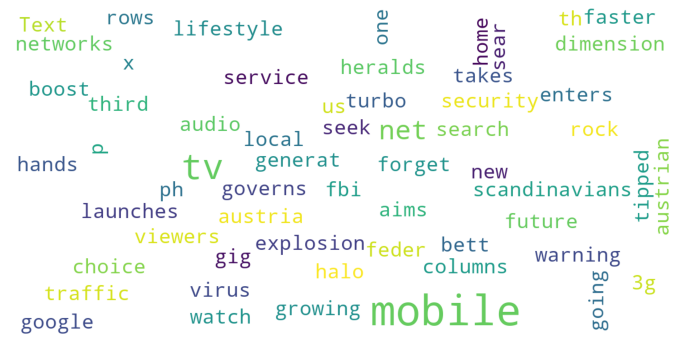

In [208]:
#Word cloud for cluster 0
#Wordcloud 
from wordcloud import WordCloud, STOPWORDS

   
wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=200,
        max_font_size=25, 
        scale=3,
        random_state=1)
    
wordcloud=wordcloud.generate(str(df.iloc[clusters[0]][['Text']]))

fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
 
plt.imshow(wordcloud)
plt.show()


In [209]:
###print cluster number and number of data points in cluster and draw the graph for the same.
print('K-Means Clustering - Assignment counts')
#Calculate number of elements in each cluster 
num_article_in_cluster = [len(v) for v in clusters]

df1 = pd.DataFrame({'Cluster Index': range(len(num_article_in_cluster)), 'Number of Data points':num_article_in_cluster}).set_index('Cluster Index')
k = 5
cluster_dict = {}
for i in range(k):
    num_article_in_cluster = df.iloc[clusters[i]][['Text','Category']].groupby("Category").count()
    cluster_dict[i] = num_article_in_cluster['Text'].to_dict()
#.groupby("Category").count()

df3 = pd.DataFrame(cluster_dict).transpose()
df3 = df3.replace(np.NaN,0)

print(df3)



K-Means Clustering - Assignment counts
   business  entertainment  politics   tech  sport
0      10.0            5.0       5.0  322.0    0.0
1      10.0            6.0     384.0    1.0    0.0
2       1.0          346.0       0.0    4.0    3.0
3       1.0            4.0       1.0   14.0  475.0
4     481.0            8.0      13.0    6.0   26.0


Text(0.5, 1.0, 'Number of Articles for Each category in Cluster - Cluster configuration by Kmeans')

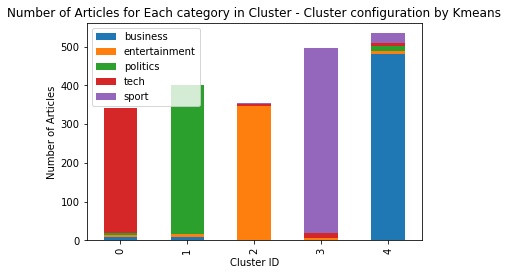

In [210]:
#f, axes = plt.subplots(1, 1, figsize=(20,5))
df3.plot.bar(stacked=True)
plt.xlabel('Cluster ID')
plt.ylabel('Number of Articles')
plt.title('Number of Articles for Each category in Cluster - Cluster configuration by Kmeans')


In [211]:
#Generate the confusion Matrix :

df['Label'] = df['Category']
df['Label'].replace(['business','entertainment','tech','politics','sport'],[4,2,0,1,3],inplace=True)
k = 5

df['predicted_label'] = 10 


for i in range(k):
    df.iloc[clusters[i],4] = i
   


In [212]:
print(df.head())

        Category                                               Text  \
0           tech  tv future in the hands of viewers with home th...   
1       business  worldcom boss  left books alone  former worldc...   
2          sport  tigers wary of farrell  gamble  leicester say ...   
3          sport  yeading face newcastle in fa cup premiership s...   
4  entertainment  ocean s twelve raids box office ocean s twelve...   

                                          clean_text  Label  predicted_label  
0  tv future hand viewer home theatre system plas...      0                0  
1  worldcom bos left book alone former worldcom b...      4                4  
2  tiger wary farrell gamble leicester say rushed...      3                3  
3  yeading face newcastle fa cup premiership side...      3                3  
4  ocean twelve raid box office ocean twelve crim...      2                2  


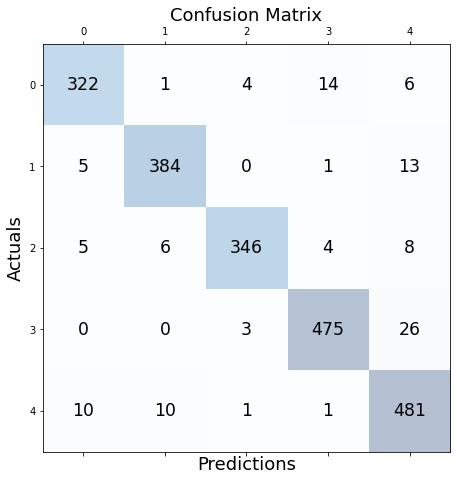

In [213]:
#K_Mean Clustering Confusion Matrix :

from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=df['Label'], y_pred=df['predicted_label'])
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [214]:
df_cluster_0 = df.iloc[clusters[0]][['Text', 'Category']]
print(df_cluster_0[df_cluster_0["Category"]!="tech"])

                                                   Text       Category
158   uk firms  embracing e-commerce  uk firms are e...       politics
159   orange colour clash set for court a row over t...       business
199   card fraudsters  targeting web  new safeguards...       business
230   tv show unites angolan families angolan famili...  entertainment
246   pupils to get anti-piracy lessons lessons on m...  entertainment
310   mps issued with blackberry threat mps will be ...       politics
381   e-university  disgraceful waste  a failed gove...       politics
441   news corp eyes video games market news corp  t...       business
847   bbc  should allow more scrutiny  mps have urge...  entertainment
962   german music in a  zombie  state the german mu...  entertainment
1011  making your office work for you our mission to...       business
1054  vodafone appoints new japan boss vodafone has ...       business
1075  news corp eyes video games market news corp  t...       business
1410  

In [215]:
df_cluster_1 = df.iloc[clusters[1]][['Text', 'Category']]
print(df_cluster_1[df_cluster_1["Category"]!="politics"])

                                                   Text       Category
37    row threatens hendrix museum plan proposals to...  entertainment
56    ukraine trims privatisation check ukraine is t...       business
338   aids and climate top davos agenda climate chan...       business
547   ink helps drive democracy in asia the kyrgyz r...           tech
826   media seek jackson  juror  notes reporters cov...  entertainment
1088  germany calls for eu reform german chancellor ...       business
1293  spector facing more legal action music produce...  entertainment
1380  world leaders gather to face uncertainty more ...       business
1461  singer ian brown  in gig arrest  former stone ...  entertainment
1532  saudi ministry to employ women women will be e...       business
1541  pete doherty misses bail deadline singer pete ...  entertainment
1578  golden rule boost for chancellor chancellor go...       business
1617  uganda bans vagina monologues uganda s authori...  entertainment
1702  

In [217]:
df_cluster_2 = df.iloc[clusters[2]][['Text', 'Category']]
print(df_cluster_2[df_cluster_2["Category"]!="entertainment"])

                                                   Text  Category
200   holmes feted with further honour double olympi...     sport
823   rank  set to sell off film unit  leisure group...  business
1146  bbc leads interactive bafta wins the bbc and t...      tech
1512  half-life 2 sweeps bafta awards pc first perso...      tech
1564  ultimate game  award for doom 3 sci-fi shooter...      tech
1897  henry tipped for fifa award fifa president sep...     sport
2146  gatlin and hayes win owen awards american olym...     sport
2200  uk pioneers digital film network the world s f...      tech


In [218]:
df_cluster_3 = df.iloc[clusters[3]][['Text', 'Category']]
print(df_cluster_3[df_cluster_3["Category"]!="sport"])

                                                   Text       Category
46    jamieson issues warning to bigots scotland s j...       politics
137   2d metal slug offers retro fun like some drill...           tech
179   arsenal  may seek full share listing  arsenal ...       business
221   world tour for top video gamers two uk gamers ...           tech
257   sporting rivals go to extra time the current s...           tech
348   rapper 50 cent ends protege feud rapper 50 cen...  entertainment
482   losing yourself in online gaming online role p...           tech
585   football manager scores big time for the past ...           tech
646   gritty return for prince of persia still baski...           tech
937   the force is strong in battlefront the warm re...           tech
964   gta sequel is criminally good the grand theft ...           tech
1127  my memories of marley...  to mark the 60th ann...  entertainment
1252  blinx sequel purrs nicely the original blinx w...           tech
1337  

In [219]:
df_cluster_4 = df.iloc[clusters[4]][['Text', 'Category']]
print(df_cluster_4[df_cluster_4["Category"]!="business"])

                                                   Text       Category
19    games maker fights for survival one of britain...           tech
82    straw praises kashmir moves the uk has welcome...       politics
150   greek sprinters suspended by iaaf greek sprint...          sport
275   report attacks defence spending the ministry o...       politics
281   thanou bullish over drugs hearing katerina tha...          sport
335   white admits to balco drugs link banned americ...          sport
361   us woman sues over cartridges a us woman is su...           tech
376   iaaf will contest greek decision the internati...          sport
384   drive to  save  festive holidays efforts are b...       politics
503   greek duo cleared in doping case sprinters kos...          sport
592   china  ripe  for media explosion asia is set t...           tech
632   us woman sues over ink cartridges a us woman i...           tech
673   msps hear renewed climate warning climate chan...       politics
677   

# Classifiers :



### Dummy classifier on Text data 


In [220]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [247]:
X = df['clean_text']
Y = df['Label']

#Train Test Validation Split 60% 20% 20%
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, Y,
    test_size=0.2, shuffle = True, random_state = 8)

#Train and validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2


print(X_train)



512     digital guru float sub pc nicholas negroponte ...
1264    poll explains free kick decision referee graha...
1578    golden rule boost chancellor chancellor gordon...
1930    circuit city get takeover offer circuit city s...
1355    smith aim bring back respect scotland manager ...
                              ...                        
1131    minister lose slopping case scottish executive...
542     act detention ruling uk urged government must ...
1357    bond game fails shake stir gaming fan word gol...
2072    hatfield executive go trial engineering firm b...
223     one define new hunt ban new law banning huntin...
Name: clean_text, Length: 1275, dtype: object


In [248]:
dict_train = {'clean_text' : X_train, 'Category' : y_train}
train_df = pd.DataFrame(dict_train) 
print(train_df)
Category_count = train_df.groupby("Category").count()
print(Category_count)


                                             clean_text  Category
512   digital guru float sub pc nicholas negroponte ...         0
1264  poll explains free kick decision referee graha...         3
1578  golden rule boost chancellor chancellor gordon...         4
1930  circuit city get takeover offer circuit city s...         4
1355  smith aim bring back respect scotland manager ...         3
...                                                 ...       ...
1131  minister lose slopping case scottish executive...         1
542   act detention ruling uk urged government must ...         1
1357  bond game fails shake stir gaming fan word gol...         0
2072  hatfield executive go trial engineering firm b...         1
223   one define new hunt ban new law banning huntin...         1

[1275 rows x 2 columns]
          clean_text
Category            
0                197
1                253
2                218
3                309
4                298


Text(0, 0.5, 'Article Count')

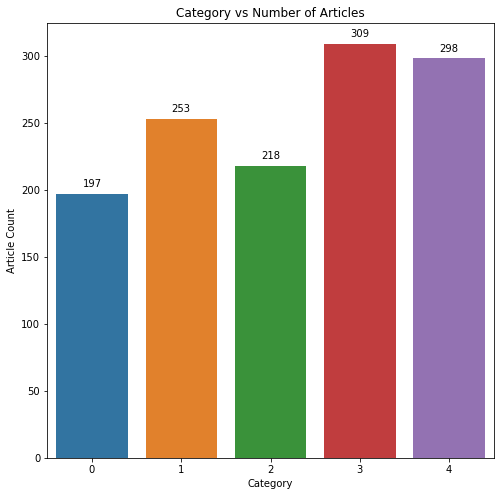

In [249]:
fig, ax = plt.subplots(figsize=(8, 8))
barchart = sns.barplot(x=Category_count.index, y=Category_count['clean_text'], ax=ax)
barchart.bar_label(ax.containers[0], label_type='edge', padding=5)
plt.title('Category vs Number of Articles')
plt.xlabel('Category')
plt.ylabel('Article Count')

In [250]:
dict_val = {'clean_text' : X_val, 'Category' : y_val}
val_df = pd.DataFrame(dict_val) 
print(val_df)
Category_count = val_df.groupby("Category").count()
print(Category_count)


                                             clean_text  Category
1367  howard denies split id card michael howard den...         1
1401  brazil play varig rescue brazilian government ...         4
1086  share hit m drug suspension share elan biogen ...         4
1702  call overhaul uk state pension uk pension syst...         4
1789  u tv special tsunami relief u television netwo...         2
...                                                 ...       ...
179   arsenal may seek full share listing arsenal vi...         4
1784  serena becomes world number two serena william...         3
1724  player sought prize uk gamers getting chance t...         0
37    row threatens hendrix museum plan proposal ope...         2
1598  fa probe crowd trouble fa take action trouble ...         3

[425 rows x 2 columns]
          clean_text
Category            
0                 88
1                 73
2                 73
3                 88
4                103


Text(0, 0.5, 'Article Count')

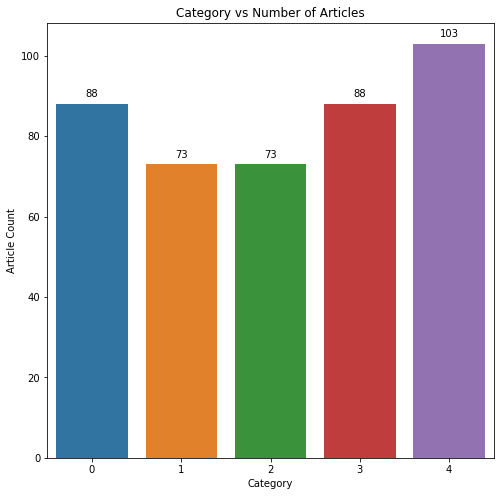

In [251]:
fig, ax = plt.subplots(figsize=(8, 8))
barchart = sns.barplot(x=Category_count.index, y=Category_count['clean_text'], ax=ax)
barchart.bar_label(ax.containers[0], label_type='edge', padding=5)
plt.title('Category vs Number of Articles')
plt.xlabel('Category')
plt.ylabel('Article Count')

In [252]:
dict_test = {'clean_text' : X_test, 'Category' : y_test}
test_df = pd.DataFrame(dict_test) 
print(test_df)
Category_count = test_df.groupby("Category").count()
print(Category_count)

                                             clean_text  Category
1393  viewer able shape tv imagine editing titanic w...         0
407   bush get tough deficit u president george w bu...         4
1076  paraguay novel win u book prize novel set th c...         2
1557  real talk gravesen move real madrid closing de...         3
2073  koubek suspended drug test stefan koubek say b...         3
...                                                 ...       ...
1208  blair look election campaign tony blair big sp...         1
355   eu slow economic reform eu country failed put ...         4
1940  iaaf awaits greek pair response kostas kenteri...         3
1890  collins appeal drug ban sprinter michelle coll...         3
272   soderling win tense milan final fifth seed rob...         3

[426 rows x 2 columns]
          clean_text
Category            
0                 62
1                 77
2                 78
3                107
4                102


Text(0, 0.5, 'Article Count')

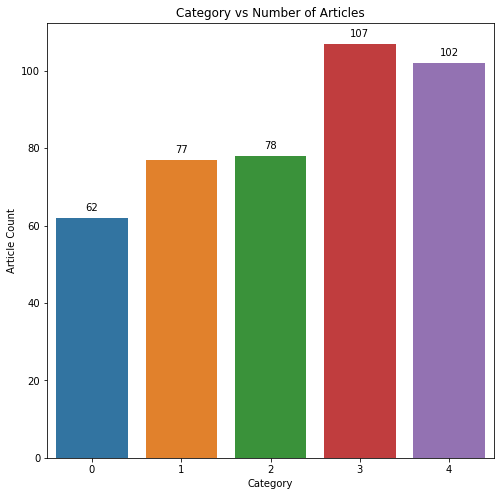

In [253]:
fig, ax = plt.subplots(figsize=(8, 8))
barchart = sns.barplot(x=Category_count.index, y=Category_count['clean_text'], ax=ax)
barchart.bar_label(ax.containers[0], label_type='edge', padding=5)
plt.title('Category vs Number of Articles')
plt.xlabel('Category')
plt.ylabel('Article Count')

In [254]:
print(y_train)

512     0
1264    3
1578    4
1930    4
1355    3
       ..
1131    1
542     1
1357    0
2072    1
223     1
Name: Label, Length: 1275, dtype: int64


### Dummy Classifier : Most Frequent

Dummy Classifier - most_frequent - Evaluation Report for Train Data :
______________________________________________________________________
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      0.000     0.000     0.000         0
           2      0.000     0.000     0.000         0
           3      1.000     0.242     0.390      1275
           4      0.000     0.000     0.000         0

    accuracy                          0.242      1275
   macro avg      0.200     0.048     0.078      1275
weighted avg      1.000     0.242     0.390      1275

Dummy Classifier - most_frequent - Evaluation Report for Validation Data : 
______________________________________________________________________
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      0.000     0.000     0.000         0
           2      0.000     0.000     0.000         0
      

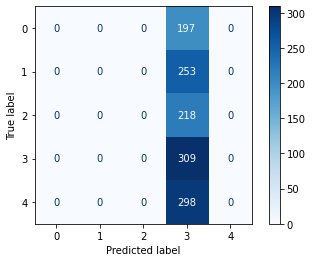

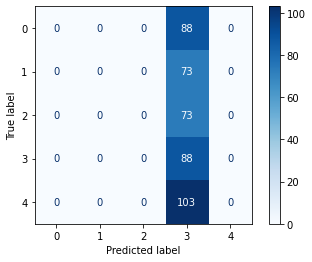

In [255]:
#Dummy classifier : Most Frequent

dclf = DummyClassifier(strategy = 'most_frequent', random_state = 0)
dclf.fit(X_train, y_train)
print("Dummy Classifier - most_frequent - Evaluation Report for Train Data :")
print("______________________________________________________________________")

print(classification_report(dclf.predict(X_train), y_train,digits=3))
plot_confusion_matrix(estimator=dclf, X=X_train, y_true=y_train,cmap='Blues')

print("Dummy Classifier - most_frequent - Evaluation Report for Validation Data : ")
print("______________________________________________________________________")
print(classification_report(dclf.predict(X_val), y_val,digits=3))
plot_confusion_matrix(estimator=dclf, X=X_val, y_true=y_val,cmap='Blues')


class_report_dummy_mf = classification_report(dclf.predict(X_train), y_train,digits=3,output_dict=True)
class_report_dummy_mf = pd.DataFrame(class_report_dummy_mf).transpose()


### Dummy Classifier : Stratified

Dummy Classifier - Stratified - Evaluation Report for Train Data :
______________________________________________________________________
              precision    recall  f1-score   support

           0      0.147     0.141     0.144       205
           1      0.174     0.168     0.171       262
           2      0.133     0.149     0.140       195
           3      0.246     0.248     0.247       306
           4      0.242     0.235     0.238       307

    accuracy                          0.196      1275
   macro avg      0.188     0.188     0.188      1275
weighted avg      0.197     0.196     0.196      1275

Dummy Classifier - Stratified - Evaluation Report for Validation Data : 
______________________________________________________________________
              precision    recall  f1-score   support

           0      0.182     0.232     0.204        69
           1      0.315     0.250     0.279        92
           2      0.151     0.216     0.177        51
           3

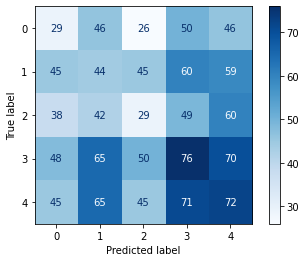

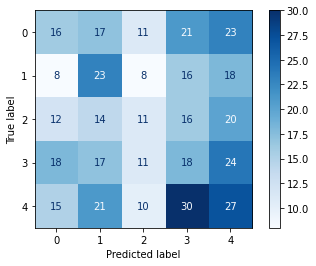

In [256]:
#Dummy classifier : Stratified

from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

dclf = DummyClassifier(strategy = 'stratified', random_state = 0)
dclf.fit(X_train, y_train)
print("Dummy Classifier - Stratified - Evaluation Report for Train Data :")
print("______________________________________________________________________")
print(classification_report(dclf.predict(X_train), y_train,digits=3))

print("Dummy Classifier - Stratified - Evaluation Report for Validation Data : ")
print("______________________________________________________________________")
print(classification_report(dclf.predict(X_val), y_val,digits=3))

class_report_dummy_s = classification_report(dclf.predict(X_train), y_train,digits=3,output_dict=True)
class_report_dummy_s = pd.DataFrame(class_report_dummy_s).transpose()

### Draw Confusion Matrix
print("Confusion Matrix - Training Data")
plot_confusion_matrix(estimator=dclf, X=X_train, y_true=y_train, cmap='Blues')

print("Confusion Matrix - Validation Data")
plot_confusion_matrix(estimator=dclf, X=X_val, y_true=y_val, cmap='Blues')


### Logistic Regression - TFIDF Vectorizer

Logistic Regression Classifier with TF/IDF vectorizer - Evaluation Report for Train Data :
______________________________________________________________________
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       197
           1      1.000     1.000     1.000       253
           2      1.000     1.000     1.000       218
           3      0.997     1.000     0.998       308
           4      1.000     0.997     0.998       299

    accuracy                          0.999      1275
   macro avg      0.999     0.999     0.999      1275
weighted avg      0.999     0.999     0.999      1275

Logistic Regression Classifier with TF/IDF vectorizer - Evaluation Report for Validation Data :
______________________________________________________________________
              precision    recall  f1-score   support

           0      0.909     0.988     0.947        81
           1      0.986     0.973     0.980        74
           2      0

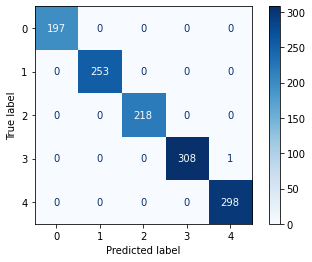

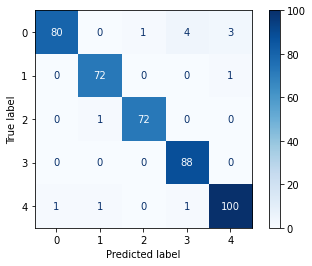

In [257]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_val_counts = count_vect.transform(X_val)
X_val_tfidf = tfidf_transformer.transform(X_val_counts)

logistic_reg = LogisticRegression()
logistic_reg.fit(X_train_tfidf, y_train)

print("Logistic Regression Classifier with TF/IDF vectorizer - Evaluation Report for Train Data :")
print("______________________________________________________________________")
print(classification_report(logistic_reg.predict(X_train_tfidf), y_train,digits=3))

print("Logistic Regression Classifier with TF/IDF vectorizer - Evaluation Report for Validation Data :")
print("______________________________________________________________________")
print(classification_report(logistic_reg.predict(X_val_tfidf), y_val,digits=3))

class_report_logit_tfidf = classification_report(logistic_reg.predict(X_val_tfidf), y_val,digits=3,output_dict=True)
class_report_logit_tfidf = pd.DataFrame(class_report_logit_tfidf).transpose()

logistic_reg
### Draw Confusion Matrix
print("Confusion Matrix - Training Data")
plot_confusion_matrix(estimator=logistic_reg, X=X_train_tfidf, y_true=y_train,cmap='Blues')
                      
print("Confusion Matrix - Validation Data")
plot_confusion_matrix(estimator=logistic_reg, X=X_val_tfidf, y_true=y_val,cmap='Blues')                     



### Logistic Regression - OneHot Vectorizer


Logistic Regression Classifier with One Hot vectorizer - Evaluation Report for Train Data :
______________________________________________________________________
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       197
           1      1.000     1.000     1.000       253
           2      1.000     1.000     1.000       218
           3      1.000     1.000     1.000       309
           4      1.000     1.000     1.000       298

    accuracy                          1.000      1275
   macro avg      1.000     1.000     1.000      1275
weighted avg      1.000     1.000     1.000      1275

Logistic Regression Classifier with One Hot vectorizer - Evaluation Report for Validation Data :
______________________________________________________________________
              precision    recall  f1-score   support

           0      0.886     0.975     0.929        80
           1      0.945     0.972     0.958        71
           2     

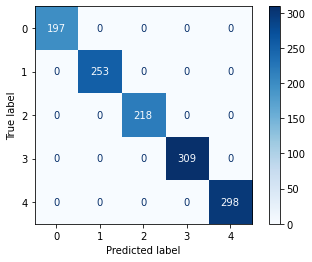

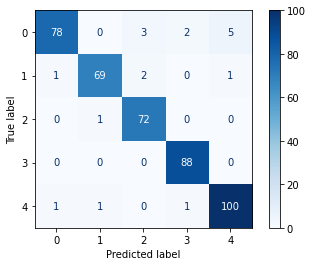

In [258]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

count_vect = CountVectorizer()
X_train_onehot = count_vect.fit_transform(X_train)
X_val_onehot = count_vect.transform(X_val)

logistic_reg = LogisticRegression()
logistic_reg.fit(X_train_onehot, y_train)

print("Logistic Regression Classifier with One Hot vectorizer - Evaluation Report for Train Data :")
print("______________________________________________________________________")
print(classification_report(logistic_reg.predict(X_train_onehot), y_train,digits=3))

print("Logistic Regression Classifier with One Hot vectorizer - Evaluation Report for Validation Data :")
print("______________________________________________________________________")
print(classification_report(logistic_reg.predict(X_val_onehot), y_val,digits=3))

class_report_logit_onehot = classification_report(logistic_reg.predict(X_train_onehot), y_train,digits=3,output_dict=True)
class_report_logit_onehot = pd.DataFrame(class_report_logit_onehot).transpose()

print("Confusion Matrix - Training Data : ")
print("____________________________________________")
plot_confusion_matrix(estimator=logistic_reg, X=X_train_onehot, y_true=y_train,cmap='Blues')
                      
print("Confusion Matrix - Validation Data : ")
print("____________________________________________")
plot_confusion_matrix(estimator=logistic_reg, X=X_val_onehot, y_true=y_val,cmap='Blues')
                      

### SVC - OneHot Vectorizer and RBF Kernel


SVC Classifier with One Hot vectorizer - Evaluation Report for Train Data :
______________________________________________________________________
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       197
           1      1.000     1.000     1.000       253
           2      1.000     1.000     1.000       218
           3      1.000     1.000     1.000       309
           4      1.000     1.000     1.000       298

    accuracy                          1.000      1275
   macro avg      1.000     1.000     1.000      1275
weighted avg      1.000     1.000     1.000      1275

SVC Classifier with One Hot vectorizer - Evaluation Report for Validation Data :
______________________________________________________________________
              precision    recall  f1-score   support

           0      0.011     1.000     0.022         1
           1      0.027     1.000     0.053         2
           2      0.041     1.000     0.079      

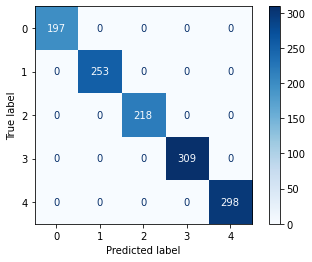

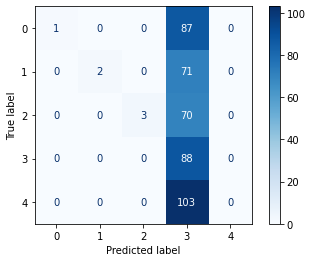

In [259]:
#SVC classifier with RBF Kernel

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

count_vect = CountVectorizer()
X_train_onehot = count_vect.fit_transform(X_train)
X_val_onehot = count_vect.transform(X_val)


svc = SVC(kernel='rbf', probability=True, C=1, gamma=0.1)
svc.fit(X_train_onehot, y_train)

print("SVC Classifier with One Hot vectorizer - Evaluation Report for Train Data :")
print("______________________________________________________________________")
print(classification_report(svc.predict(X_train_onehot), y_train,digits=3))

print("SVC Classifier with One Hot vectorizer - Evaluation Report for Validation Data :")
print("______________________________________________________________________")
print(classification_report(svc.predict(X_val_onehot), y_val,digits=3))

class_report_svc_onehot = classification_report(svc.predict(X_val_onehot), y_val,digits=3,output_dict=True)
class_report_svc_onehot = pd.DataFrame(class_report_svc_onehot).transpose()
#print(class_report_logit_tfidf)

logistic_reg
### Draw Confusion Matrix
print("Confusion Matrix - Training Data")
plot_confusion_matrix(estimator=svc, X=X_train_onehot, y_true=y_train,cmap='Blues')

print("Confusion Matrix - Validation Data")
plot_confusion_matrix(estimator=svc, X=X_val_onehot, y_true=y_val,cmap='Blues')
                      

## SVC with One Hot Vectorizer and Linear Kernel

SVC Classifier with One Hot vectorizer and Linear Kernel - Evaluation Report for Train Data :
______________________________________________________________________
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       197
           1      1.000     1.000     1.000       253
           2      1.000     1.000     1.000       218
           3      1.000     1.000     1.000       309
           4      1.000     1.000     1.000       298

    accuracy                          1.000      1275
   macro avg      1.000     1.000     1.000      1275
weighted avg      1.000     1.000     1.000      1275

SVC Classifier with One Hot vectorizer and Linear Kernel - Evaluation Report for Validation Data :
______________________________________________________________________
              precision    recall  f1-score   support

           0      0.920     0.976     0.947        83
           1      0.932     0.971     0.951        70
           2 

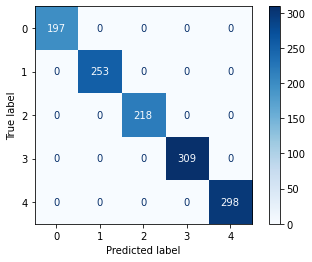

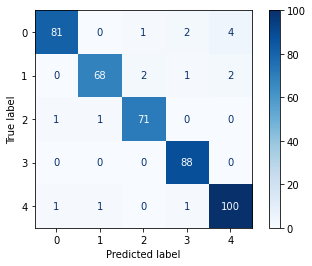

In [261]:
#SVC classifier with Linear Kernel

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

count_vect = CountVectorizer()
X_train_onehot = count_vect.fit_transform(X_train)
X_val_onehot = count_vect.transform(X_val)


svc = SVC(kernel='linear', probability=True, C=1, gamma=0.1)
svc.fit(X_train_onehot, y_train)

print("SVC Classifier with One Hot vectorizer and Linear Kernel - Evaluation Report for Train Data :")
print("______________________________________________________________________")
print(classification_report(svc.predict(X_train_onehot), y_train,digits=3))

print("SVC Classifier with One Hot vectorizer and Linear Kernel - Evaluation Report for Validation Data :")
print("______________________________________________________________________")
print(classification_report(svc.predict(X_val_onehot), y_val,digits=3))

class_report_svc_onehot = classification_report(svc.predict(X_train_onehot), y_train,digits=3,output_dict=True)
class_report_svc_onehot = pd.DataFrame(class_report_svc_onehot).transpose()

### Draw Confusion Matrix
print("Confusion Matrix - Training Data")
plot_confusion_matrix(estimator=svc, X=X_train_onehot, y_true=y_train,cmap='Blues')

print("Confusion Matrix - Validation Data")
plot_confusion_matrix(estimator=svc, X=X_val_onehot, y_true=y_val,cmap='Blues')
                      

### Logistic Regression classifier with TF-IDF - Macro F1 Score for Each Class

In [278]:
print(class_report_logit_tfidf)

              precision    recall  f1-score     support
0              0.909091  0.987654  0.946746   81.000000
1              0.986301  0.972973  0.979592   74.000000
2              0.986301  0.986301  0.986301   73.000000
3              1.000000  0.946237  0.972376   93.000000
4              0.970874  0.961538  0.966184  104.000000
accuracy       0.969412  0.969412  0.969412    0.969412
macro avg      0.970513  0.970941  0.970240  425.000000
weighted avg   0.970808  0.969412  0.969624  425.000000


Text(0, 0.5, 'F1-Score')

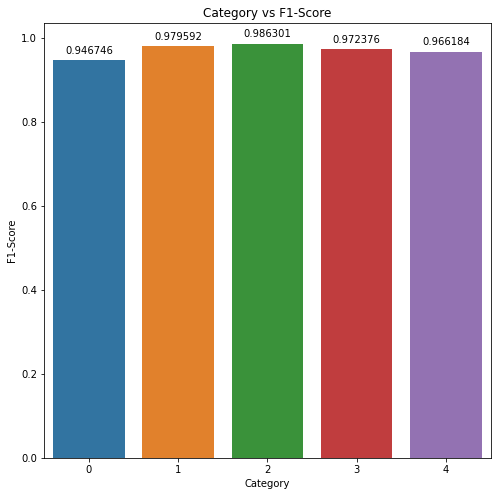

In [279]:
fig, ax = plt.subplots(figsize=(8, 8))
barchart = sns.barplot(x=class_report_logit_tfidf.iloc[:5].index, y=class_report_logit_tfidf.iloc[:5]['f1-score'], ax=ax)
barchart.bar_label(ax.containers[0], label_type='edge', padding=5)
plt.title('Category vs F1-Score')
plt.xlabel('Category')
plt.ylabel('F1-Score')

### My Own Classifier

### NaiveByes classifier - TfIDF vectorizer


Naive Bayes Classifier with TF/IDF vectorizer - Evaluation Report for Train Data :
______________________________________________________________________
              precision    recall  f1-score   support

           0      0.970     1.000     0.985       191
           1      0.996     0.958     0.977       263
           2      0.963     1.000     0.981       210
           3      0.997     1.000     0.998       308
           4      0.993     0.977     0.985       303

    accuracy                          0.986      1275
   macro avg      0.984     0.987     0.985      1275
weighted avg      0.986     0.986     0.986      1275

Naive Bayes Classifier with TF/IDF vectorizer - Evaluation Report for Validation Data :
______________________________________________________________________
              precision    recall  f1-score   support

           0      0.898     0.988     0.940        80
           1      1.000     0.912     0.954        80
           2      0.945     1.000  

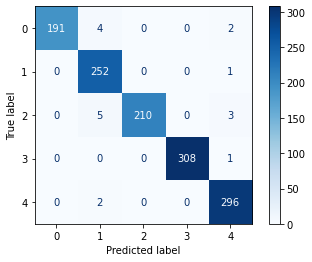

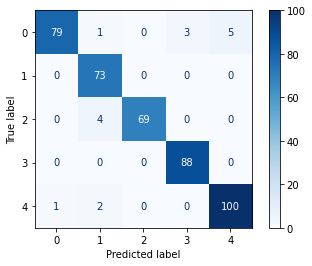

In [264]:
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_val_counts = count_vect.transform(X_val)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_val_tfidf = tfidf_transformer.transform(X_val_counts)

NB_clf = MultinomialNB().fit(X_train_tfidf, y_train)

print("Naive Bayes Classifier with TF/IDF vectorizer - Evaluation Report for Train Data :")
print("______________________________________________________________________")
print(classification_report(NB_clf.predict(X_train_tfidf), y_train,digits=3))

print("Naive Bayes Classifier with TF/IDF vectorizer - Evaluation Report for Validation Data :")
print("______________________________________________________________________")
print(classification_report(NB_clf.predict(X_val_tfidf), y_val,digits=3))

class_report_NB_tfidf = classification_report(NB_clf.predict(X_val_tfidf), y_val,digits=3,output_dict=True)
class_report_NB_tfidf = pd.DataFrame(class_report_NB_tfidf).transpose()

### Draw Confusion Matrix
print("Confusion Matrix - Training Data")
plot_confusion_matrix(estimator=NB_clf, X=X_train_tfidf, y_true=y_train,cmap='Blues')
                       
print("Confusion Matrix - Validation Data")
plot_confusion_matrix(estimator=NB_clf, X=X_val_tfidf, y_true=y_val,cmap='Blues')


# Hyperparameter Tuning


In [274]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

param_grid = {'C': [100, 10, 1.0, 0.1, 0.01], 'sublinear_df': [True, False], 'max_features': [10000, 25000, 50000], 'penalty':['l2'], 'solver':['newton-cg', 'sag', 'lbfgs', 'liblinear']} 

best_params, best_f1 = None, 0
for params in ParameterGrid(param_grid):
    vectorizer = TfidfVectorizer(sublinear_tf=params['sublinear_df'],max_features=params['max_features'])
    X_train_hp = vectorizer.fit_transform(X_train)
    X_val_hp = vectorizer.transform(X_val)
    
    clf = LogisticRegression(random_state=42, C=params['C'], solver=params['solver'], penalty=params['penalty'])
    clf.fit(X_train_hp,y_train)
    
    labels_predicted = clf.predict(X_val_hp)
    
    f1 = f1_score(y_val, labels_predicted, average='macro')
    print(f"  Evaluating {params=} {f1=:.3f}")

    if f1 > best_f1:
        best_params = params
        best_f1 = f1

print(f"{best_params=}")
print(f"{best_f1=:.3f}")

  Evaluating params={'C': 100, 'max_features': 10000, 'penalty': 'l2', 'solver': 'newton-cg', 'sublinear_df': True} f1=0.984
  Evaluating params={'C': 100, 'max_features': 10000, 'penalty': 'l2', 'solver': 'newton-cg', 'sublinear_df': False} f1=0.977
  Evaluating params={'C': 100, 'max_features': 10000, 'penalty': 'l2', 'solver': 'sag', 'sublinear_df': True} f1=0.984
  Evaluating params={'C': 100, 'max_features': 10000, 'penalty': 'l2', 'solver': 'sag', 'sublinear_df': False} f1=0.977
  Evaluating params={'C': 100, 'max_features': 10000, 'penalty': 'l2', 'solver': 'lbfgs', 'sublinear_df': True} f1=0.984
  Evaluating params={'C': 100, 'max_features': 10000, 'penalty': 'l2', 'solver': 'lbfgs', 'sublinear_df': False} f1=0.977
  Evaluating params={'C': 100, 'max_features': 10000, 'penalty': 'l2', 'solver': 'liblinear', 'sublinear_df': True} f1=0.984
  Evaluating params={'C': 100, 'max_features': 10000, 'penalty': 'l2', 'solver': 'liblinear', 'sublinear_df': False} f1=0.975
  Evaluating par

  Evaluating params={'C': 1.0, 'max_features': 50000, 'penalty': 'l2', 'solver': 'sag', 'sublinear_df': False} f1=0.970
  Evaluating params={'C': 1.0, 'max_features': 50000, 'penalty': 'l2', 'solver': 'lbfgs', 'sublinear_df': True} f1=0.982
  Evaluating params={'C': 1.0, 'max_features': 50000, 'penalty': 'l2', 'solver': 'lbfgs', 'sublinear_df': False} f1=0.970
  Evaluating params={'C': 1.0, 'max_features': 50000, 'penalty': 'l2', 'solver': 'liblinear', 'sublinear_df': True} f1=0.980
  Evaluating params={'C': 1.0, 'max_features': 50000, 'penalty': 'l2', 'solver': 'liblinear', 'sublinear_df': False} f1=0.970
  Evaluating params={'C': 0.1, 'max_features': 10000, 'penalty': 'l2', 'solver': 'newton-cg', 'sublinear_df': True} f1=0.914
  Evaluating params={'C': 0.1, 'max_features': 10000, 'penalty': 'l2', 'solver': 'newton-cg', 'sublinear_df': False} f1=0.888
  Evaluating params={'C': 0.1, 'max_features': 10000, 'penalty': 'l2', 'solver': 'sag', 'sublinear_df': True} f1=0.914
  Evaluating par

Logistic Regression Classifier Hyperparameter Tuning - Evaluation Report for Train Data :
______________________________________________________________________
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       197
           1      1.000     1.000     1.000       253
           2      1.000     1.000     1.000       218
           3      1.000     1.000     1.000       309
           4      1.000     1.000     1.000       298

    accuracy                          1.000      1275
   macro avg      1.000     1.000     1.000      1275
weighted avg      1.000     1.000     1.000      1275

Logistic Regression Classifier Hyperparameter Tuning - Evaluation Report for Validation Data :
______________________________________________________________________
              precision    recall  f1-score   support

           0      0.955     0.988     0.971        85
           1      1.000     0.973     0.986        75
           2      0.9

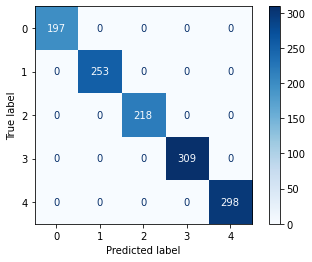

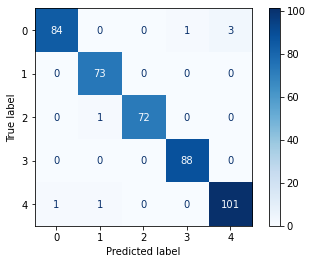

In [277]:
vectorizer = TfidfVectorizer(sublinear_tf=True,max_features=10000)
X_train_hp1 = vectorizer.fit_transform(X_train)
X_val_hp1 = vectorizer.transform(X_val)
    
clf1 = LogisticRegression(random_state=42, C=100, solver='newton-cg', penalty='l2')
clf1.fit(X_train_hp1,y_train)

print("Logistic Regression Classifier Hyperparameter Tuning - Evaluation Report for Train Data :")
print("______________________________________________________________________")
print(classification_report(clf1.predict(X_train_hp1), y_train,digits=3))

print("Logistic Regression Classifier Hyperparameter Tuning - Evaluation Report for Validation Data :")
print("______________________________________________________________________")
print(classification_report(clf1.predict(X_val_hp1), y_val,digits=3))

class_report_logit_hp = classification_report(clf1.predict(X_val_hp1), y_val,digits=3,output_dict=True)
class_report_logit_hp = pd.DataFrame(class_report_logit_hp).transpose()

logistic_reg
### Draw Confusion Matrix
print("Confusion Matrix - Training Data")
plot_confusion_matrix(estimator=clf1, X=X_train_hp1, y_true=y_train,cmap='Blues')
                      
print("Confusion Matrix - Validation Data")
plot_confusion_matrix(estimator=clf1, X=X_val_hp1, y_true=y_val,cmap='Blues')                     

    

# Evaluation of Logistic Regression with TF/IDF and Hyperparameter Tuning on Test Set

Logistic Regression Classifier Hyperparameter Tuning - Evaluation Report for Test Data :
______________________________________________________________________
              precision    recall  f1-score   support

           0      0.919     0.983     0.950        58
           1      0.935     0.935     0.935        77
           2      0.987     0.987     0.987        78
           3      1.000     0.982     0.991       109
           4      0.961     0.942     0.951       104

    accuracy                          0.965       426
   macro avg      0.960     0.966     0.963       426
weighted avg      0.965     0.965     0.965       426

Confusion Matrix - Test Data


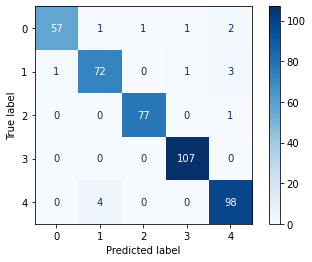

In [280]:
X_test_hp1 = vectorizer.transform(X_test)
print("Logistic Regression Classifier Hyperparameter Tuning - Evaluation Report for Test Data :")
print("______________________________________________________________________")
print(classification_report(clf1.predict(X_test_hp1), y_test,digits=3))

class_report_logit_hp_test = classification_report(clf1.predict(X_test_hp1), y_test,digits=3,output_dict=True)
class_report_logit_hp_test = pd.DataFrame(class_report_logit_hp_test).transpose()

print("Confusion Matrix - Test Data")
plot_confusion_matrix(estimator=clf1, X=X_test_hp1, y_true=y_test,cmap='Blues')                     

    

In [286]:
df_pred_test = pd.DataFrame({'Text': X_test, 'True_Label' : y_test, 'pred_label' : clf1.predict(X_test_hp1)})
df_pred_test1 = df_pred_test[df_pred_test['True_Label']!=df_pred_test['pred_label']]


In [289]:
df_pred_test1.sort_values(by=['pred_label'],inplace=True)


In [290]:
df_pred_test1


,Text,True_Label,pred_label
158,uk firm embracing e commerce uk firm embracing...,1,0
338,aid climate top davos agenda climate change fi...,4,1
378,parent face video game lesson way ensuring par...,0,1
1809,golden rule intact say ex aide chancellor gord...,4,1
1532,saudi ministry employ woman woman employed sau...,4,1
1380,world leader gather face uncertainty business ...,4,1
1146,bbc lead interactive bafta win bbc national th...,0,2
585,football manager score big time past decade vi...,0,3
1581,howard truanted play snooker conservative lead...,1,3
2204,argonaut founder rebuilds empire jez san man b...,0,4
